## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100.000 рублей;
* Турция — 60.000 рублей;
* Мальдивы — 200.000 рублей;
* Санкт-Петербург — 10.000 рублей;
* Камчатка — 150.000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu

from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
url = 'https://drive.google.com/file/d/152KF4uo2BaKtHmMFFACT3HV01KMBhEfj/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

tourist = pd.read_csv(path, compression = 'zip')
tourist.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

**Colums "date" contains data type - OBJECT**

In [3]:
tourist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?

**A/B testing has been ran between 2nd and 24th of January 2021**

In [4]:
tourist['date'] = pd.to_datetime(tourist['date'])
tourist.groupby('group')['date'].agg(['min', 'max'])

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
visits = tourist.groupby('group')['user_id'].agg('count')
purchases = tourist.groupby('group')['purchase'].agg('sum')
sales = tourist.groupby('group')['price'].agg('sum') / 1e06

print('Number of visits in each group A & B: {}'.format(visits))
print('Number of purchases in each group A & B: {}'.format(purchases))
print('Amount of purchases in each group A & B: {}'.format(sales))

Number of visits in each group A & B: group
A    147202
B    147276
Name: user_id, dtype: int64
Number of purchases in each group A & B: group
A    17723
B    17514
Name: purchase, dtype: int64
Amount of purchases in each group A & B: group
A    1436.26
B    1554.10
Name: price, dtype: float64


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [6]:
a_tourist = tourist[tourist['group'] == 'A']
b_tourist = tourist[tourist['group'] == 'B']

a_set = set(a_tourist['user_id'])
b_set = set(b_tourist['user_id'])

set_intersection = a_set.intersection(b_set)
print(len(set_intersection))

1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [7]:
updated_tourist = tourist[tourist['user_id'].apply(lambda x: x not in set_intersection)]

Где set_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

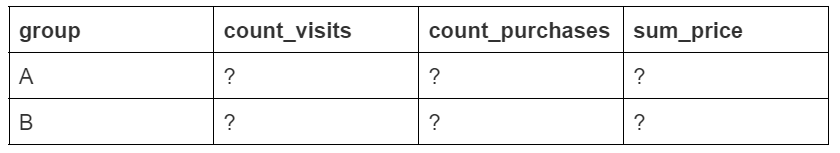
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [8]:
grouped = updated_tourist.groupby('group').agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).rename(columns = {
    'user_id':'count_visits',
    'purchase':'count_purchases',
    'price':'sum_price'
})
display(grouped)

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

### **Conclusion:**

##### *We see that number of web-site visits in group B is a little bit higher compare to group A (0.05%), but number of purchases at the same time lower (1.13%). Seems like that option B of the web-site lead people to purchase more expensive tours, because the spendings in group B higher for 7.5% or 115 million RUR*

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [9]:
grouped['conversion'] = grouped['count_purchases'] / grouped['count_visits']*100
grouped['mean_check'] = grouped['sum_price'] / grouped['count_purchases']

display(grouped['conversion'].round(2))
display(grouped['mean_check'].round())

display(grouped)

group
A    12.03
B    11.89
Name: conversion, dtype: float64

group
A    81076.0
B    88665.0
Name: mean_check, dtype: float64

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.034520,81076.228055
B,145381,17290,1533010000,11.892888,88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

### **Conclusion:**

##### *Option A of web page lead people to make a little bit more purchases. In other words, more people are buying compare to option B. But at the same time the average check in group A is lower than in group B. Seems like people in group B are spending more than in group B, even though the number of purchases are less than in group A.*

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [10]:
pivot = updated_tourist[updated_tourist['price'] > 0].pivot_table(
index = 'group',
columns = 'price',
values = 'purchase',
aggfunc = 'sum')
display(pivot)

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

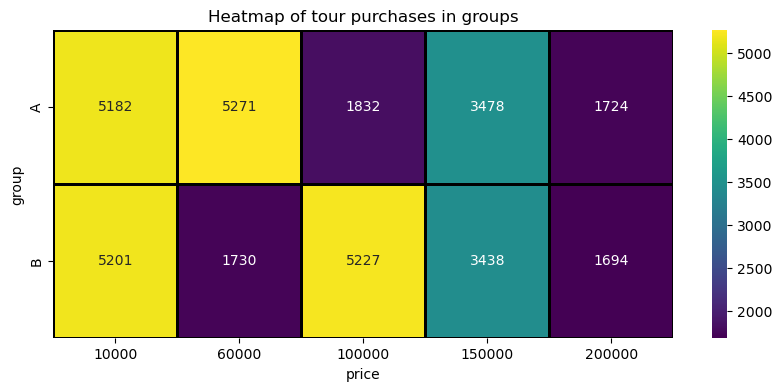

In [11]:
fig = plt.figure(figsize = (10,4))
ax = sns.heatmap(pivot, annot = True, cmap = 'viridis', fmt = '.0f', 
                 linecolor = 'black', linewidths = 1)
ax.set_title('Heatmap of tour purchases in groups');

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

### **Conclusion:**

##### *People in group A are more willing to buy tours in Turkey, but people from group B prefer to travel to Thailand. And there are more or less same number of people in group A and B who like Sankt-Petersburg and Kamchatka.*


## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [12]:
daily_data = updated_tourist.groupby(['date', 'group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns = {
    'user_id':'count_visits',
    'purchase':'count_purchases',
    'price':'sum_price'
})

daily_data['conversion'] = daily_data['count_purchases'] / daily_data['count_visits']*100
daily_data['mean_check'] = daily_data['sum_price'] / daily_data['count_purchases']

display(daily_data.head())

display(daily_data[daily_data['date'] == 
                   pd.to_datetime('2021-01-03')][['group', 'conversion']].round(2))
display(daily_data[daily_data['date'] == 
                  pd.to_datetime('2021-01-03')][['group', 'mean_check']].round())

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270


,group,conversion
2,A,11.34
3,B,11.39


,group,mean_check
2,A,82888.0
3,B,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [13]:
# Cumulative number of visits
daily_data['cum_count_visits'] = daily_data.groupby('group')['count_visits'].cumsum()

# Cumulative number of purchases
daily_data['cum_count_purchases'] = daily_data.groupby('group')['count_purchases'].cumsum()

#Cumulative sum of purchases
daily_data['cum_sum_price'] = daily_data.groupby('group')['sum_price'].cumsum()

#Cumulative conversion
daily_data['cum_conversion'] = daily_data['cum_count_purchases'] / daily_data['cum_count_visits']*100

#Cumulative mean check
daily_data['cum_mean_check'] = daily_data['cum_sum_price'] / daily_data['cum_count_purchases']

display(daily_data[daily_data['date'] == pd.to_datetime('2021-01-20')][['group', 'cum_conversion']].round(2))
display(daily_data[daily_data['date'] == pd.to_datetime('2021-01-12')][['group', 'cum_mean_check']].round())

display(daily_data.sample(5))

,group,cum_conversion
36,A,11.98
37,B,11.90


,group,cum_mean_check
20,A,81492.0
21,B,88352.0


,date,group,count_visits,count_purchases,sum_price,conversion,mean_check,cum_count_visits,cum_count_purchases,cum_sum_price,cum_conversion,cum_mean_check
36,2021-01-20,A,6533,749,58710000,11.464871,78384.512684,121506,14561,1179590000,11.983770,81010.232814
17,2021-01-10,B,6701,846,78080000,12.624981,92293.144208,55937,6659,590150000,11.904464,88624.418081
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270,16016,1906,155660000,11.900599,81668.415530
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101,9480,1099,95620000,11.592827,87006.369427
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571,2854,359,29410000,12.578837,81922.005571


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

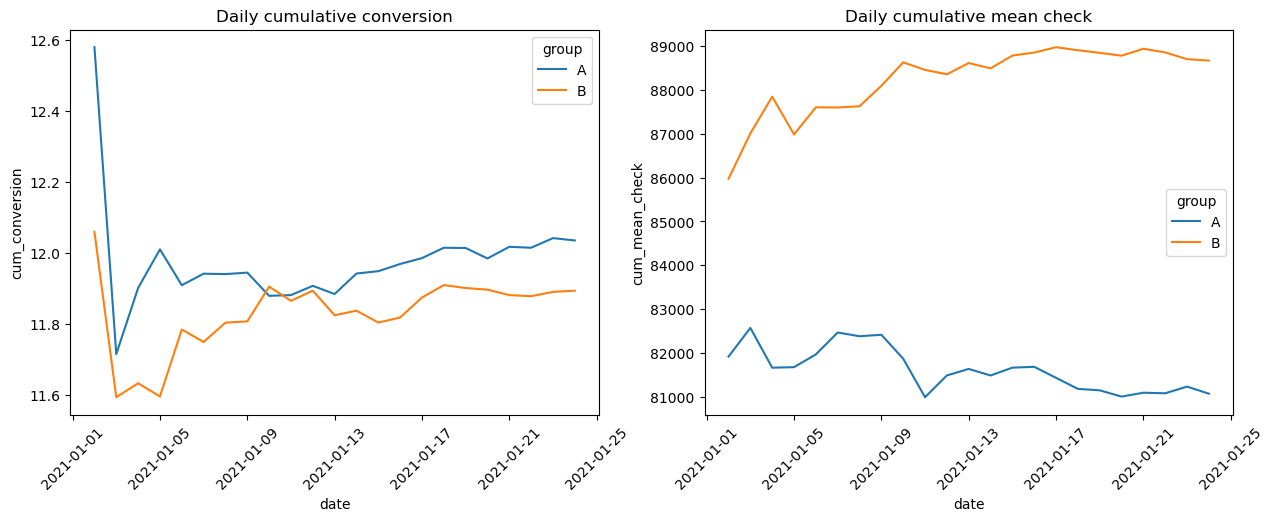

In [14]:
fig, axes = plt.subplots(1,2, figsize = (15,5))
sns.lineplot(x = 'date',
            y = 'cum_conversion',
            hue = 'group',
            data = daily_data,
            ax = axes[0])

sns.lineplot(x = 'date',
            y = 'cum_mean_check',
            data = daily_data,
            hue = 'group',
            ax = axes[1])

axes[0].set_title('Daily cumulative conversion')
axes[1].set_title('Daily cumulative mean check')

axes[0].xaxis.set_tick_params(rotation = 45)
axes[1].xaxis.set_tick_params(rotation = 45)

### **Conclusion:**

##### *In general it can be confirmed that the values of both metrics have stabilized within the reviewed period. The "Cumulative conversion" chart shows that the number of purchases in group A is a bit higher compare to group B and the respective value is stable. At the same time the cumulative average check in group B is significantly higher than in group A and the tendency is flowing comparably stable over the period, which is clearly shown on "Daily cumulative mean check" graph. A/B testing is completed.*


## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [15]:
# Statistical significance in conversions shall be checked by performing z-test.

# Count number of success and obnservations in each group.
transactions_piv = tourist.groupby('group')['purchase'].agg(['sum', 'count'])

print(transactions_piv)

H0 = 'Conversions in group A & B are equal'
H1 = 'Conversion in group A is greater than in group B'

alpha = 0.05

_, p_value = proportions_ztest(count = transactions_piv['sum'],
                             nobs = transactions_piv['count'],
                             alternative = 'larger')

print('p_values:', round(p_value, 2))

if (p_value < alpha):
    print('Reject null hypothesis, {}'.format(H0))
    print('Alternative hypothesis. H1:'.format(H1))
else:
    print('Accept null hypothesis. {}'.format(H0))

         sum   count
group               
A      17723  147202
B      17514  147276
p_values: 0.11
Accept null hypothesis. Conversions in group A & B are equal


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

### **Conclusion:**

##### *Z-test shows that p-value is 0.11 which is higher than level of significance (0.05), therefore the Null Hypothesis is accepted, meaning that both version of web page lead statistically same number of people to make the purchase .*

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [16]:
a_data = updated_tourist[updated_tourist['group'] == 'A']
b_data = updated_tourist[updated_tourist['group'] == 'B']

def proportions_conf_interval(n, x_p, gamma = 0.95):
    alpha = 1-gamma
    z_crit = -norm.ppf(alpha/2)
    eps = z_crit * (x_p * (1-x_p)/n)**0.5
    lower_bound = x_p - eps
    upper_bound = x_p + eps
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

conf_interval_a = proportions_conf_interval(n = a_data['user_id'].count(),
                                           x_p = a_data['purchase'].mean())

conf_interval_b = proportions_conf_interval(n = b_data['user_id'].count(),
                                           x_p = b_data['purchase'].mean())

print('Confidence interval for group A conversion: {}'.format(conf_interval_a))
print('Confidence interval for group B conversion: {}'.format(conf_interval_b))

def diff_proportions_conf_interval(n, xp, gamma = 0.95):
    alpha = 1-gamma
    diff = xp[1] - xp[0]
    z_crit = -norm.ppf(alpha/2)
    eps = z_crit * (xp[0]*(1-xp[0])/n[0] + 
                    xp[1]*(1-xp[1])/n[1])**0.5
    lower_bound = diff - eps
    upper_bound = diff + eps
    
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

n = [a_data['user_id'].count(),
    b_data['user_id'].count()]

xp = [a_data['purchase'].mean(),
     b_data['purchase'].mean()]

diff_interval = diff_proportions_conf_interval(n, xp)

print('Confidence interval for conversion difference: {}'.format(diff_interval))

Confidence interval for group A conversion: (11.87, 12.2)
Confidence interval for group B conversion: (11.73, 12.06)
Confidence interval for conversion difference: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

### **Conclusion:**

##### *The confidence interval with 95% confidence states that the difference between group B and group A conversion is between -0.38 and 0.09; interval covers point zero. There is no statistical difference between conversions in group A and B. Both options of web page lead the same number of people to make the purchase.*

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [17]:
daily_a = daily_data[daily_data['group'] == 'A']
daily_b = daily_data[daily_data['group'] == 'B']

H0 = 'Distribution in both groups is normal'
H1 = 'Distribution in one or both groups is not normal'

alpha = 0.05

shapiro_result_a = shapiro(daily_a['mean_check'])
shapiro_result_b = shapiro(daily_b['mean_check'])

print('p-value group A', round(shapiro_result_a.pvalue, 2))
print('p-value group B', round(shapiro_result_b.pvalue, 2))

if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print('Reject null hypothesis. {}'.format(H0))
    print('Alternative hypothesis. H1: {}'.format(H1))
    
else:
    print('Accept null hypothesis. {}'.format(H0))

p-value group A 0.25
p-value group B 0.09
Accept null hypothesis. Distribution in both groups is normal


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [18]:
H0 = 'Daily average check in group A & B are equal'
H1 = 'Daily average check in group A is less than in group B'

alpha = 0.05

results_t = ttest_ind(a = daily_a['mean_check'],
                   b = daily_b['mean_check'],
                   alternative = 'less')

print('p-value: ', round(results_t.pvalue, 2))

if (results_t.pvalue < alpha):
    print(f'Reject null hypothesis. {H0}')
    print(f'Accept alternative hypothesis. {H1}')
else:
    print('Accept null hypothesis. {}'.format(H0))

p-value:  0.0
Reject null hypothesis. Daily average check in group A & B are equal
Accept alternative hypothesis. Daily average check in group A is less than in group B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

### **Conclusion:**

##### *The average check in group B is greater than in group A.*

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [19]:
# Confidence interval for average check in each group

def mean_check_conf_interval(n, x_mean, x_std, gamma = 0.95):
    k = n-1
    alpha = 1-gamma
    t_crit = -t.ppf(alpha / 2, k)
    eps = t_crit * x_std / n ** 0.5
    lower_bound = x_mean - eps
    upper_bound = x_mean + eps
    
    return round(lower_bound), round(upper_bound)

params_a = {'n': daily_a['count_visits'].count(),
           'x_mean': daily_a['mean_check'].mean(),
           'x_std': daily_a['mean_check'].std()}

params_b = {'n': daily_b['count_visits'].count(),
           'x_mean': daily_b['mean_check'].mean(),
           'x_std': daily_b['mean_check'].std()}

print('Confidence interval for average check in group A: {}'.format(mean_check_conf_interval(**params_a)))
print('Confidence interval for average check in group B: {}'.format(mean_check_conf_interval(**params_b)))


Confidence interval for average check in group A: (79630, 82308)
Confidence interval for average check in group B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

### **Conclusion:**

##### *The average daily spendings are not ovelapping in each group. And the amount of funds people are spending in group B is significantly higher compare to spendings in group A.*

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

### **Conclusion:**

#### To my opinion the version B of the web site is more efficient in regards of conversion and average check, because:
**- the number of purchases in both groups are statistically equal;**

**- but the average spendings in group B is higher than in group A.**